## Importing Liberary

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dropout,GlobalAveragePooling2D,BatchNormalization,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score,f1_score,precision_score,accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import cv2
import os

### Loading directory of color images

In [6]:
# As we read in research paper with color data in EfficientNetB5 he get 99.6 accuracy. so, we decide to take color data.
root_path = 'color/'

In [3]:
img_rows, img_cols = 224,224
arr = os.listdir(root_path)
print(arr)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',

In [4]:
count = []
for i in os.listdir(root_path):
    l = len(os.listdir(root_path+i))
    count.append(l)

In [5]:
class_count = {key:value for key,value in enumerate(count)}

In [6]:
class_count.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37])

### Plotting Image Counts

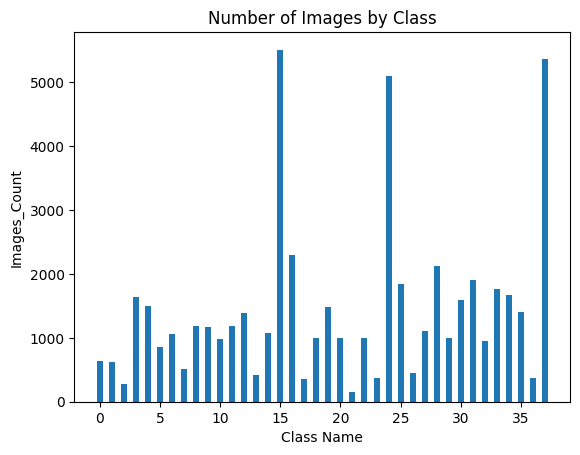

In [7]:
#For ploting EDA I take help from https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a
plt.bar(class_count.keys(), class_count.values(), width = .5);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('Images_Count');

## Observatio
#### 1) As we can see class 15 (Orange___Haunglongbing_(Citrus_greening)) and class 37 (Tomato___Tomato_Yellow_Leaf_Curl_Virus) have large image count as compare to other classes.
#### 2) And class 21 (Potato___healthy) have least image count.
#### 3) As we can see our data is not balance some classes have higher images and some have low images.

### Plotting Image Shape

In [8]:
def image_shape(path):
    index = [i for i in range(len(os.listdir(root_path+path)))]
    df = pd.DataFrame(index = index,columns=['height','width'])
    for i,j in enumerate(os.listdir(root_path+path)):
        image = cv2.imread(root_path+path+'/'+j)
        h,w,d = image.shape
        df['height'][i] = h
        df['width'][i] = w
    return df

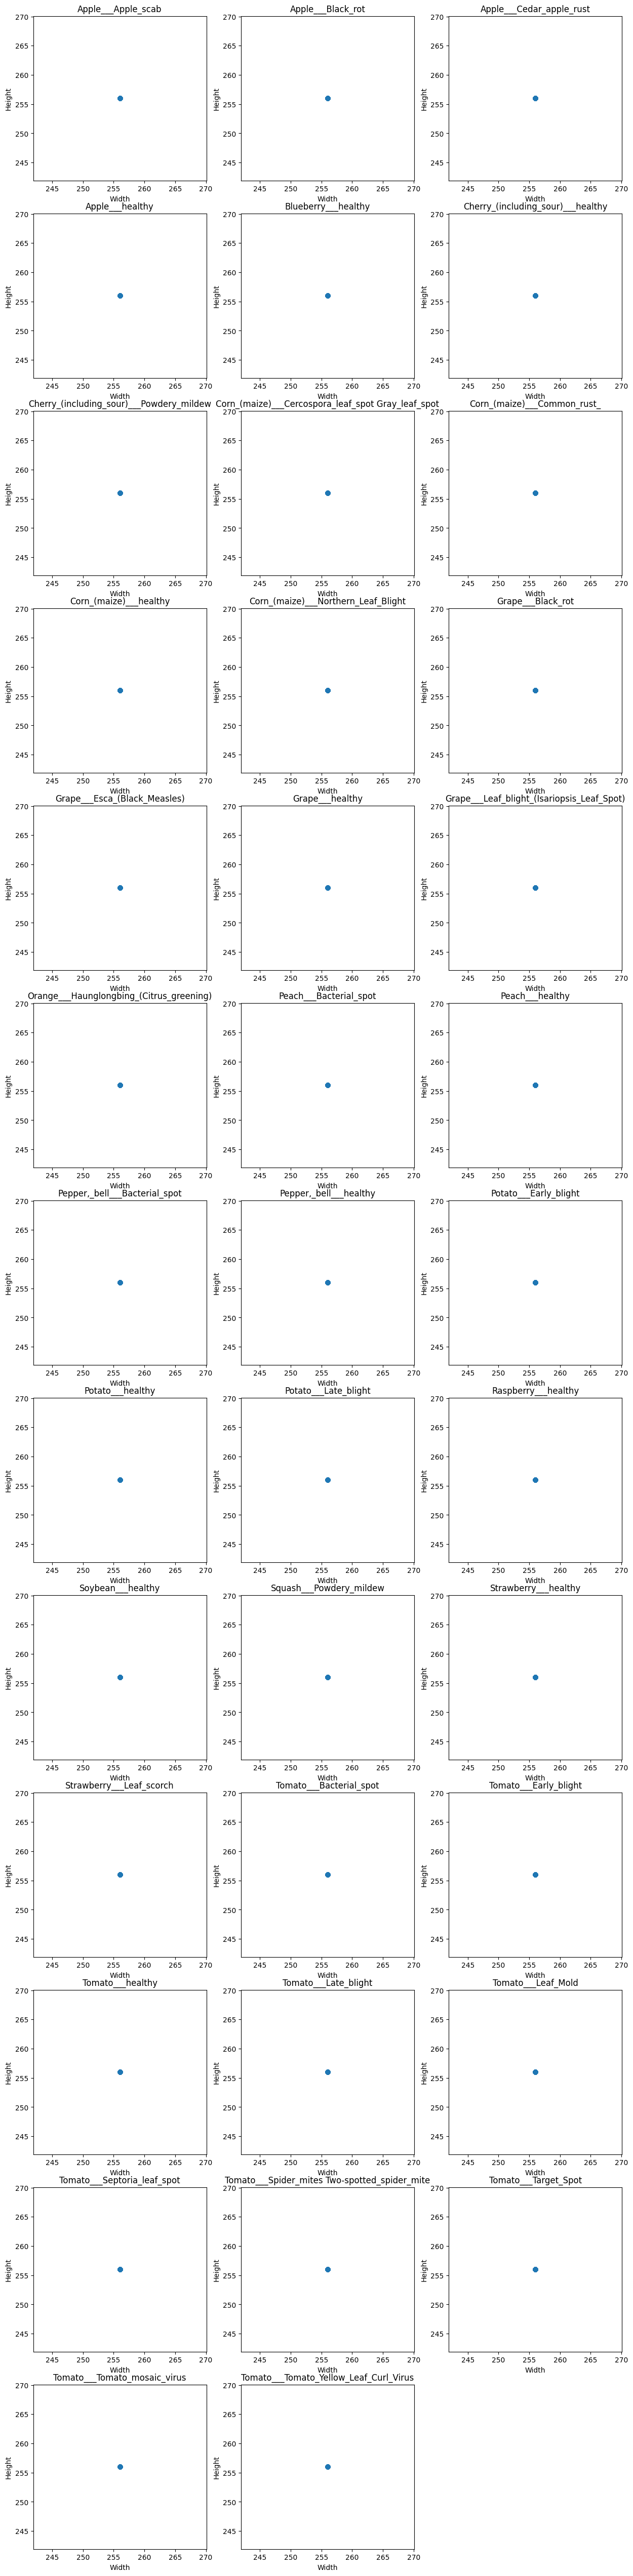

In [66]:
#For subploting I take help from my previous linear Model assignment
s = 0
plt.figure(figsize=(15,65))
for path in arr:
    s += 1
    size = image_shape(path)
    
    plt.subplot(13, 3, s)
    
    plt.scatter(size['height'],size['width'])
    
    plt.xlabel('Width')
    plt.ylabel('Height')
    
    plt.title('{}'.format(path))

## Observation
#### As we can see above our data have same dimension in all feature image data.

### Visualizing Our Data

In [8]:
image = cv2.imread('color\Apple___Black_rot/00e909aa-e3ae-4558-9961-336bb0f35db3___JR_FrgE.S 8593.jpg')
image = cv2.resize(image, (224,224))

Plant Image - Apple___Black_rot


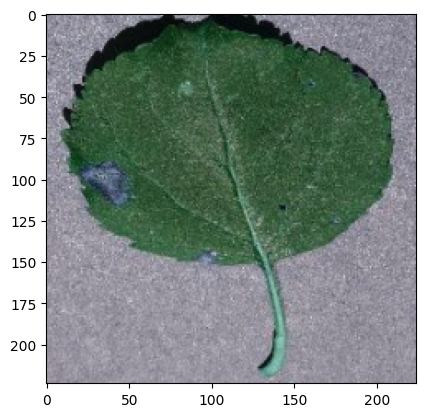

In [9]:
# As we can see our train data have[Image_index][0: for image data and 1: for label][Index]
print('Plant Image - {}'.format('Apple___Black_rot'))
plt.imshow(image)
plt.show()

### Dataset Generator

In [2]:
INPUT_SHAPE = (224,224)

In [3]:
def split_data(data_dir):
    l = []
    p = []
    Data = pd.DataFrame(columns= ['filepaths','labels'])
    for i in os.listdir(root_path):
        for j in os.listdir(root_path+i):
            label = i
            path = root_path+i+'/' + j
            p.append(path)
            l.append(label)
    Data['filepaths'] = p
    Data['labels'] = l
    train_df, test_df = train_test_split(Data,  train_size= 0.8, shuffle= True, random_state= 123, stratify= Data['labels'])
    
    return train_df, test_df

In [7]:
train_df, test_df = split_data(root_path)

In [8]:
#From Transfer_Learning_Assignment I get this blog
#https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
datagen = ImageDataGenerator(zoom_range = 0.2,horizontal_flip = True,rotation_range=15,vertical_flip=True,
                             brightness_range=[0.5, 1.5],validation_split=0.2)        #https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [9]:
X_test = datagen.flow_from_dataframe(test_df, x_col= 'filepaths', y_col= 'labels',class_mode='categorical',
                                      target_size=INPUT_SHAPE,color_mode= 'rgb', shuffle= True, batch_size= 1,subset='training')

Found 8689 validated image filenames belonging to 38 classes.


In [10]:
X_val = datagen.flow_from_dataframe(test_df, x_col= 'filepaths', y_col= 'labels',class_mode='categorical',
                                      target_size=INPUT_SHAPE,color_mode= 'rgb', shuffle= True, batch_size= 24,subset='validation')

Found 2172 validated image filenames belonging to 38 classes.


In [11]:
#From Transfer_Learning_Assignment I get this blog
#https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

datagen = ImageDataGenerator(zoom_range = 0.2,horizontal_flip = True,rotation_range=15,vertical_flip=True,
                             brightness_range=[0.5, 1.5])       #https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

X_train = datagen.flow_from_dataframe(train_df, x_col= 'filepaths', y_col= 'labels',class_mode='categorical',
                                      target_size=INPUT_SHAPE,color_mode= 'rgb', shuffle= True, batch_size= 24)

Found 43444 validated image filenames belonging to 38 classes.


In [12]:
Label = list(X_train.class_indices.keys())

## Building Call_Backs

In [19]:
#https://medium.com/@shubhamkabre/step-by-step-solution-of-deep-learning-for-pneumonia-detection-from-chest-x-ray-images-5bb272eb8548
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(
                               K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
       
        true_positives = K.sum(K.round(
                                     K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives +  K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives +  K.epsilon())
    return precision

In [20]:
def changeLearningRate(epoch,lr):
    #here we are performing exponential decay of the learning rate
    #initial_learningrate=0.001
    if (epoch+1) % 15 == 0:
      lr = lr * 0.02
    return lr

In [18]:
model = EfficientNetB5(include_top=False, input_shape=(224, 224, 3), weights="imagenet")             #https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB5

In [19]:
model.trainable = True

In [20]:
input_layer = model.output    #Get this method from classrom query resolution, https://www.tensorflow.org/api_docs/python/tf/keras/Model

layer1 = GlobalAveragePooling2D()(input_layer)    

layer2 = BatchNormalization()(layer1)

layer3 = Dropout(0.2)(layer2)

#output layer
output = Dense(38, activation="softmax")(layer3)

# creating the final model 
model = Model(inputs=model.input, outputs = output)   #https://www.tensorflow.org/api_docs/python/tf/keras/Model
# compile the model 
optimizer = Adam(beta_1 = 0.9, beta_2 = 0.999, decay = 0.0,learning_rate=0.001)

model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics=["accuracy",f1,recall,precision])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [24]:
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)                 #https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

filepath="Model_1/weight.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')        #https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

lrschedule = LearningRateScheduler(changeLearningRate, verbose=1)                      #https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler


reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,patience=5, min_lr=0.001)               #https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau

# here we are creating a list with all the callbacks we want
callback_list = [lrschedule,reduce_lr, checkpoint,tensorboard_callback]

In [27]:
model.fit(X_train,validation_data = X_val,epochs=25,verbose=1,callbacks=callback_list)

C:\Users\Harshit - dev\anaconda3\envs\try\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/25

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
1811/1811 [==============================] - 1088s 586ms/step - loss: 0.5356 - accuracy: 0.8657 - f1: 0.8675 - recall: 0.8504 - precision: 0.8881 - val_loss: 0.1974 - val_accuracy: 0.9434 - val_f1: 0.9463 - val_recall: 0.9396 - val_precision: 0.9534

Epoch 00001: val_accuracy improved from -inf to 0.94337, saving model to Model_1\weight.hdf5
Epoch 2/25

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
1811/1811 [==============================] - 1031s 569ms/step - loss: 0.2430 - accuracy: 0.9338 - f1: 0.9350 - recall: 0.9296 - precision: 0.9407 - val_loss: 5.4655 - val_accuracy: 0.6994 - val_f1: 0.7031 - val_recall: 0.6896 - val_precision: 0.7179

Epoch 00002: val_accuracy did not improve from 0.94337
Epoch 3/25

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
1811/1811 [==============================] - 1032s 570ms/step - l

In [32]:
# !pip install -q tf-nightly-2.0-preview
# if you want to use the tf2.0 please uncomment the above line
# Load the TensorBoard notebook extension

# there are other ways of doing this: https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/ you can try this way also
%load_ext tensorboard

In [33]:
%tensorboard --logdir logs/fits

## Observation

#### 1) Train accuracy and Validation accuracy are approximately same.

#### 2) Train accuracy increases constantly approximately and validation accuracy decreases after epoch 4 after that it also increases.

#### 3) Train and Validation F1_Score are approximately same.

#### 4) Train and Validation F1_Score,Precision,Recall approximately follow same pattern as accuracy graph.

#### 5) At epoch 0 validation loss is high and after that it start decreases and at the end both train and validation loss is approximately same.

#### 6) At epoch 7 validation loss increases after that it decreases c onstantly.

### Loading Best Model Weight

In [21]:
model.load_weights('Model_1\weight.hdf5')

### Evaluating Our Model On Unseen Data

In [26]:
model.evaluate(X_test)

8689/8689 [==============================] - 890s 101ms/step - loss: 0.0107 - accuracy: 0.9972 - f1: 0.9972 - recall: 0.9972 - precision: 0.9972


[0.010734477080404758,
 0.9972378611564636,
 0.9972378015518188,
 0.9972378015518188,
 0.9972378015518188]

### Observation
#### Unseen data accuracy we get is 99.78 and F1_Score 99.7816


### Testing And Building classification Report On Unseen Data

In [23]:
y_true = []
y_pred = []
for i in range(len(X_test)):
    pred = np.argmax(model.predict(X_test[i][0]))
    true = np.argmax(X_test[i][1])
    y_true.append(true)
    y_pred.append(pred)

In [29]:
# Classification report
print(classification_report(y_true, y_pred, target_names= Label))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00       106
                                 Apple___Black_rot       1.00      1.00      1.00        98
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        44
                                   Apple___healthy       1.00      1.00      1.00       269
                               Blueberry___healthy       1.00      1.00      1.00       240
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       163
                 Cherry_(including_sour)___healthy       1.00      0.99      1.00       139
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.92      0.98      0.95        81
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       196
               Corn_(maize)___Northern_Leaf_Blight       0.99      0.96      0.

In [30]:
def final_fun_1(X):
    label = ['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___healthy','Blueberry___healthy','Cherry_(including_sour)___Powdery_mildew','Cherry_(including_sour)___healthy','Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot','Corn_(maize)___Common_rust_','Corn_(maize)___Northern_Leaf_Blight','Corn_(maize)___healthy','Grape___Black_rot','Grape___Esca_(Black_Measles)','Grape___Leaf_blight_(Isariopsis_Leaf_Spot)','Grape___healthy','Orange___Haunglongbing_(Citrus_greening)','Peach___Bacterial_spot','Peach___healthy','Pepper,_bell___Bacterial_spot','Pepper,_bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Raspberry___healthy','Soybean___healthy','Squash___Powdery_mildew','Strawberry___Leaf_scorch','Strawberry___healthy','Tomato___Bacterial_spot','Tomato___Early_blight','Tomato___Late_blight','Tomato___Leaf_Mold','Tomato___Septoria_leaf_spot','Tomato___Spider_mites Two-spotted_spider_mite','Tomato___Target_Spot','Tomato___Tomato_Yellow_Leaf_Curl_Virus','Tomato___Tomato_mosaic_virus','Tomato___healthy']
    img = image.load_img(X, grayscale=False, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = np.array(x, 'float32')
    datagen = ImageDataGenerator(zoom_range = 0.2,horizontal_flip = True,rotation_range=15,vertical_flip=True,brightness_range=[0.5, 1.5])
    img = datagen.flow(x, batch_size=1)
    pred = np.argmax(model.predict(img))
    
    return label[pred]

In [32]:
print(final_fun_1('color\Apple___Black_rot/0b8dabb7-5f1b-4fdc-b3fa-30b289707b90___JR_FrgE.S 3047.JPG'))

Apple___Black_rot


In [46]:
def final_fun_2(y_true,y_pred):
    return accuracy_score(y_true,y_pred),f1_score(y_true,y_pred,average='micro')

In [48]:
acuracy,f1_score = final_fun_2(y_true,y_pred)
print('Accuracy:- {}\nF1_Score:- {}'.format(acuracy,f1_score))

Accuracy:- 0.9975831511105996
F1_Score:- 0.9975831511105996


### Web site Link:- http://ec2-13-50-225-245.eu-north-1.compute.amazonaws.com:8080/